In [14]:
# --- Step 5: Hierarchical Clustering Analysis for Spatial Organization ---
# This analyzes whether neurons with similar RFs cluster together physically

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

import importlib

import numpy as np
import utils as U
importlib.reload(U)

<module 'utils' from '/Users/aakarsh/src/TUE-SUMMER-2025/nds-final-project-summer25/utils.py'>

In [15]:
directory_path = "./data/aakarsh/rf_fitting/"
rf_data_path = U.find_latest_file(directory_path)
# load the npz file 
rf_data = np.load(rf_data_path)
all_rfs_spatiotemporal = rf_data['all_rfs_spatiotemporal']
all_rfs_spatial = rf_data['all_rfs_spatial']

Starting hierarchical clustering analysis...
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating centers of spatial receptive fields...
RF center calculation complete.
Analyzing 189 neurons...
With 3 clusters: ARI score = -0.008
With 5 clusters: ARI score = 0.004
With 7 clusters: ARI score = -0.005
With 10 clusters: ARI score = 0.005


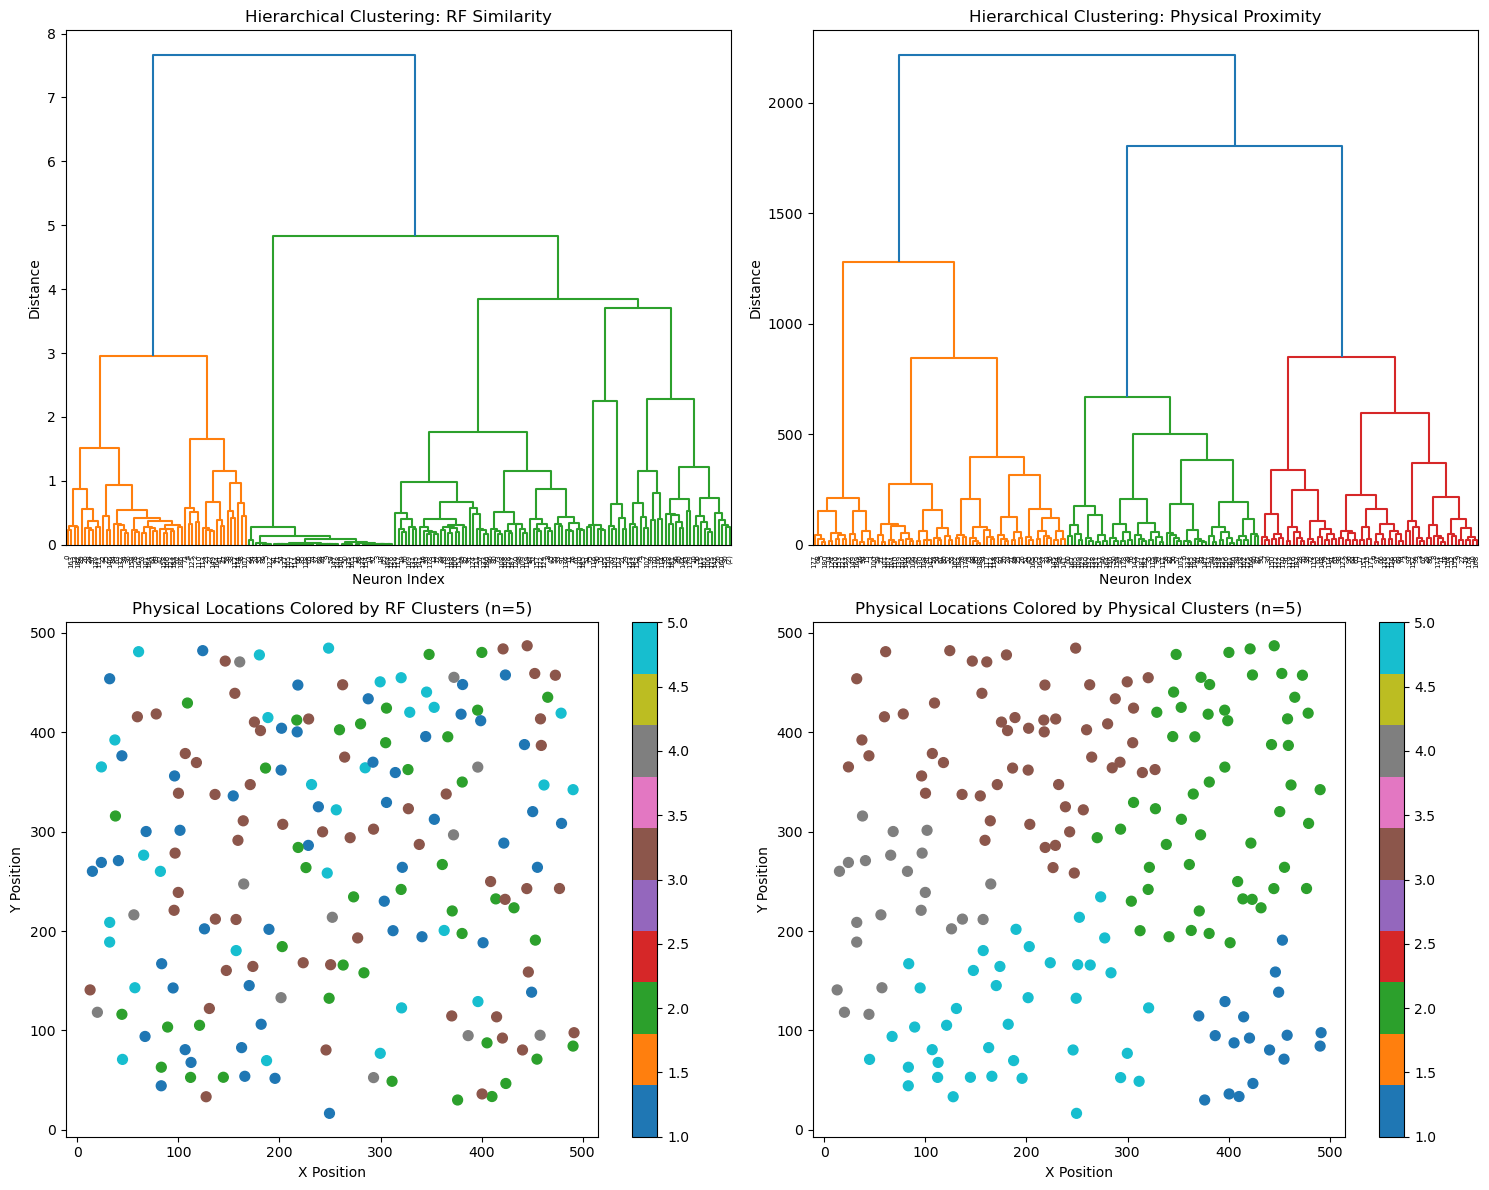


--- Testing Statistical Significance ---
Performing permutation test to assess if clustering similarity is significant...
Observed ARI score: 0.0041
P-value: 0.2470
Mean null ARI: -0.0002
✗ NOT SIGNIFICANT: No evidence for spatial organization of RFs


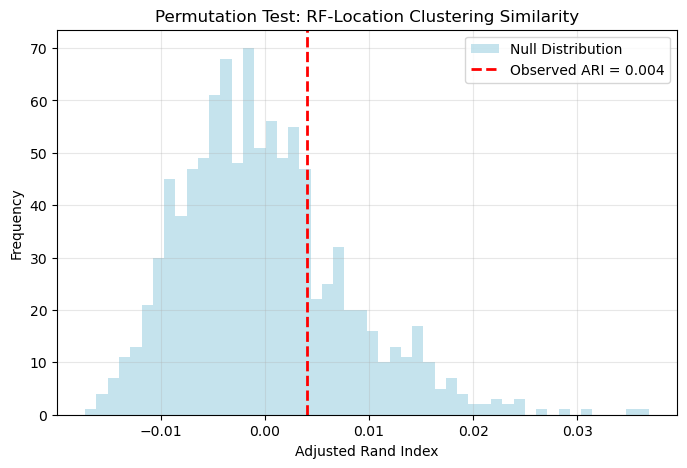

Hierarchical clustering analysis complete!


In [16]:

print("Starting hierarchical clustering analysis...")

# First, we need the physical locations of neurons (ROI centroids)
# Load this from the original data since we need it for spatial analysis
original_data = np.load("dff_data_rf.npz", allow_pickle=True)
roi_masks = original_data["roi_masks"]
max_projection = original_data["max_projection"]

# Calculate physical centroids of neurons
roi_centroids = U.calculate_roi_centroids(roi_masks)

# Calculate RF centers from the spatial receptive fields
rf_centers = U.calculate_rf_centers(all_rfs_spatial)

print(f"Analyzing {len(all_rfs_spatial)} neurons...")

# --- 1. Hierarchical Clustering Based on RF Similarity ---
# Flatten the spatial RFs for clustering
rf_features = np.array([rf.flatten() for rf in all_rfs_spatial])

# Calculate pairwise distances between RFs
rf_distances = pdist(rf_features, metric='correlation')

# Perform hierarchical clustering on RF similarity
rf_linkage = linkage(rf_distances, method='ward')

# --- 2. Hierarchical Clustering Based on Physical Location ---
# Calculate pairwise distances between physical locations
physical_distances = pdist(roi_centroids, metric='euclidean')

# Perform hierarchical clustering on physical proximity
physical_linkage = linkage(physical_distances, method='ward')

# --- 3. Compare the two clustering structures ---
# Extract cluster labels for different numbers of clusters
n_clusters_to_test = [3, 5, 7, 10]
comparison_results = {}

for n_clusters in n_clusters_to_test:
    # Get cluster labels from RF similarity
    rf_clusters = fcluster(rf_linkage, n_clusters, criterion='maxclust')
    
    # Get cluster labels from physical proximity  
    physical_clusters = fcluster(physical_linkage, n_clusters, criterion='maxclust')
    
    # Calculate how similar the two clusterings are
    ari_score = adjusted_rand_score(rf_clusters, physical_clusters)
    comparison_results[n_clusters] = {
        'rf_clusters': rf_clusters,
        'physical_clusters': physical_clusters,
        'ari_score': ari_score
    }
    
    print(f"With {n_clusters} clusters: ARI score = {ari_score:.3f}")

# --- 4. Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: RF similarity dendrogram
axes[0,0].set_title("Hierarchical Clustering: RF Similarity")
dendrogram(rf_linkage, ax=axes[0,0], truncate_mode='level', p=10)
axes[0,0].set_xlabel("Neuron Index")
axes[0,0].set_ylabel("Distance")

# Plot 2: Physical proximity dendrogram  
axes[0,1].set_title("Hierarchical Clustering: Physical Proximity")
dendrogram(physical_linkage, ax=axes[0,1], truncate_mode='level', p=10)
axes[0,1].set_xlabel("Neuron Index")
axes[0,1].set_ylabel("Distance")

# Plot 3: Spatial map colored by RF clusters
n_clusters_viz = 5
rf_clusters_viz = comparison_results[n_clusters_viz]['rf_clusters']
scatter1 = axes[1,0].scatter(roi_centroids[:, 1], roi_centroids[:, 0], 
                            c=rf_clusters_viz, cmap='tab10', s=50)
axes[1,0].set_title(f"Physical Locations Colored by RF Clusters (n={n_clusters_viz})")
axes[1,0].set_xlabel("X Position")
axes[1,0].set_ylabel("Y Position")
plt.colorbar(scatter1, ax=axes[1,0])

# Plot 4: Spatial map colored by physical clusters
physical_clusters_viz = comparison_results[n_clusters_viz]['physical_clusters']
scatter2 = axes[1,1].scatter(roi_centroids[:, 1], roi_centroids[:, 0], 
                            c=physical_clusters_viz, cmap='tab10', s=50)
axes[1,1].set_title(f"Physical Locations Colored by Physical Clusters (n={n_clusters_viz})")
axes[1,1].set_xlabel("X Position") 
axes[1,1].set_ylabel("Y Position")
plt.colorbar(scatter2, ax=axes[1,1])

plt.tight_layout()
plt.show()

# --- 5. Statistical Significance Test ---
print("\n--- Testing Statistical Significance ---")
print("Performing permutation test to assess if clustering similarity is significant...")

def permutation_test_clustering(rf_features, roi_centroids, n_permutations=1000, n_clusters=5):
    """Test if RF-based and location-based clustering similarity is significant."""
    
    # Calculate observed ARI score
    rf_distances = pdist(rf_features, metric='correlation')
    physical_distances = pdist(roi_centroids, metric='euclidean')
    
    rf_linkage = linkage(rf_distances, method='ward')
    physical_linkage = linkage(physical_distances, method='ward')
    
    rf_clusters = fcluster(rf_linkage, n_clusters, criterion='maxclust')
    physical_clusters = fcluster(physical_linkage, n_clusters, criterion='maxclust')
    
    observed_ari = adjusted_rand_score(rf_clusters, physical_clusters)
    
    # Generate null distribution by permuting RF assignments
    null_aris = []
    for i in range(n_permutations):
        # Randomly shuffle RF assignments to neurons
        shuffled_indices = np.random.permutation(len(rf_features))
        shuffled_rf_features = rf_features[shuffled_indices]
        
        # Recalculate clustering with shuffled RFs
        shuffled_rf_distances = pdist(shuffled_rf_features, metric='correlation')
        shuffled_rf_linkage = linkage(shuffled_rf_distances, method='ward')
        shuffled_rf_clusters = fcluster(shuffled_rf_linkage, n_clusters, criterion='maxclust')
        
        # Calculate ARI with shuffled data
        null_ari = adjusted_rand_score(shuffled_rf_clusters, physical_clusters)
        null_aris.append(null_ari)
    
    # Calculate p-value
    p_value = np.mean(np.array(null_aris) >= observed_ari)
    
    return observed_ari, p_value, null_aris

# Run the permutation test
observed_ari, p_value, null_distribution = permutation_test_clustering(
    rf_features, roi_centroids, n_permutations=1000, n_clusters=5
)

print(f"Observed ARI score: {observed_ari:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Mean null ARI: {np.mean(null_distribution):.4f}")

if p_value < 0.05:
    print("✓ SIGNIFICANT: Neurons with similar RFs tend to cluster together physically!")
else:
    print("✗ NOT SIGNIFICANT: No evidence for spatial organization of RFs")

# Plot the null distribution
plt.figure(figsize=(8, 5))
plt.hist(null_distribution, bins=50, alpha=0.7, label='Null Distribution', color='lightblue')
plt.axvline(observed_ari, color='red', linestyle='--', linewidth=2, label=f'Observed ARI = {observed_ari:.3f}')
plt.xlabel('Adjusted Rand Index')
plt.ylabel('Frequency')
plt.title('Permutation Test: RF-Location Clustering Similarity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Hierarchical clustering analysis complete!")

=== DBSCAN Analysis for Spatial Structure ===

DBSCAN Advantages for Spatial Neuroscience:
1. Finds clusters of arbitrary shape (not just spherical)
2. Automatically determines number of clusters
3. Identifies outliers (neurons that don't fit any spatial pattern)
4. Works well with varying cluster densities
5. No assumption about cluster size

1. Finding spatial clusters based on physical neuron locations...
Optimal epsilon: 0.200
Found 25 physical clusters
Outliers: 57 neurons

2. Finding clusters based on receptive field similarity...
Optimal RF epsilon: 0.100
Found 0 RF clusters
RF outliers: 189 neurons

=== KEY METRICS FOR EVALUATING SPATIAL STRUCTURE ===
1. Correlation Metrics (Most Important):
   Distance Correlation: r = 0.0140, p = 0.0623
   Retinotopy X: r = -0.0645, p = 0.3777
   Retinotopy Y: r = -0.0685, p = 0.3487

2. Clustering Agreement:
   Adjusted Rand Index: N/A (insufficient clusters)

3. Within vs Between Cluster Analysis:
   Within-cluster RF similarity: 0.1550
   

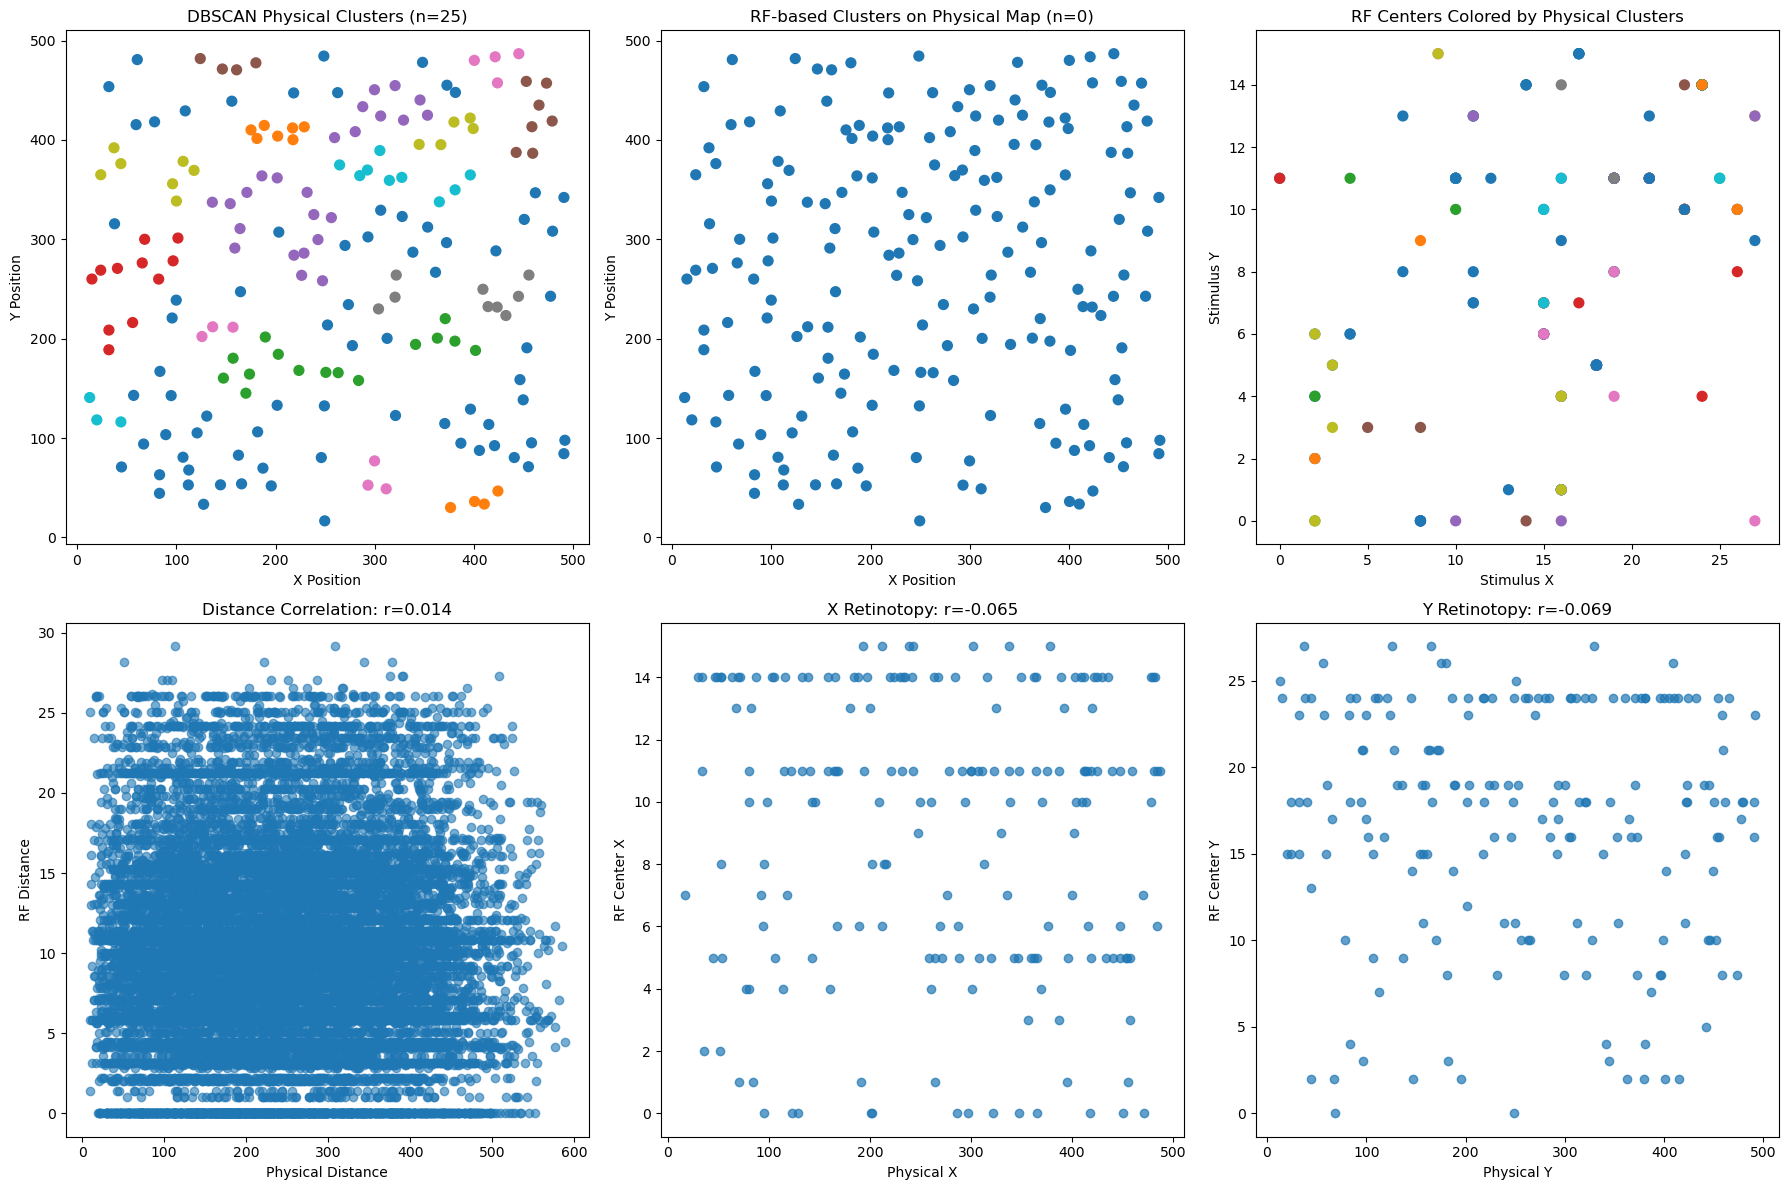


=== FINAL SPATIAL STRUCTURE ASSESSMENT ===

Evidence Score: 0/5

CONCLUSION: WEAK/NO EVIDENCE for spatial structure in receptive fields

DBSCAN Analysis Complete!


In [17]:
# --- Step 6: DBSCAN Analysis and Comprehensive Spatial Structure Metrics ---
# DBSCAN is excellent for finding spatial clusters without pre-specifying cluster numbers

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

print("=== DBSCAN Analysis for Spatial Structure ===")

# --- Why DBSCAN is Great for This Problem ---
print("""
DBSCAN Advantages for Spatial Neuroscience:
1. Finds clusters of arbitrary shape (not just spherical)
2. Automatically determines number of clusters
3. Identifies outliers (neurons that don't fit any spatial pattern)
4. Works well with varying cluster densities
5. No assumption about cluster size
""")

# --- 1. DBSCAN on Physical Locations ---
print("1. Finding spatial clusters based on physical neuron locations...")

# Standardize coordinates for DBSCAN
scaler_physical = StandardScaler()
roi_centroids_scaled = scaler_physical.fit_transform(roi_centroids)

# Try different epsilon values to find optimal clustering
epsilon_values = np.linspace(0.1, 2.0, 20)
dbscan_results = {}

for eps in epsilon_values:
    dbscan_physical = DBSCAN(eps=eps, min_samples=3)
    physical_clusters_db = dbscan_physical.fit_predict(roi_centroids_scaled)
    
    n_clusters = len(set(physical_clusters_db)) - (1 if -1 in physical_clusters_db else 0)
    n_outliers = list(physical_clusters_db).count(-1)
    
    if n_clusters > 1:  # Only calculate silhouette if we have clusters
        try:
            silhouette_avg = silhouette_score(roi_centroids_scaled, physical_clusters_db)
        except:
            silhouette_avg = -1
    else:
        silhouette_avg = -1
        
    dbscan_results[eps] = {
        'n_clusters': n_clusters,
        'n_outliers': n_outliers,
        'silhouette': silhouette_avg,
        'labels': physical_clusters_db
    }

# Find optimal epsilon
best_eps = max(dbscan_results.keys(), 
               key=lambda x: dbscan_results[x]['silhouette'] if dbscan_results[x]['silhouette'] > 0 else -1)

optimal_physical_clusters = dbscan_results[best_eps]['labels']
print(f"Optimal epsilon: {best_eps:.3f}")
print(f"Found {dbscan_results[best_eps]['n_clusters']} physical clusters")
print(f"Outliers: {dbscan_results[best_eps]['n_outliers']} neurons")

# --- 2. DBSCAN on RF Features ---
print("\n2. Finding clusters based on receptive field similarity...")

# Standardize RF features
scaler_rf = StandardScaler()
rf_features_scaled = scaler_rf.fit_transform(rf_features)

# Find optimal clustering for RFs
rf_dbscan_results = {}
for eps in epsilon_values:
    dbscan_rf = DBSCAN(eps=eps, min_samples=3)
    rf_clusters_db = dbscan_rf.fit_predict(rf_features_scaled)
    
    n_clusters = len(set(rf_clusters_db)) - (1 if -1 in rf_clusters_db else 0)
    n_outliers = list(rf_clusters_db).count(-1)
    
    if n_clusters > 1:
        try:
            silhouette_avg = silhouette_score(rf_features_scaled, rf_clusters_db)
        except:
            silhouette_avg = -1
    else:
        silhouette_avg = -1
        
    rf_dbscan_results[eps] = {
        'n_clusters': n_clusters,
        'n_outliers': n_outliers,
        'silhouette': silhouette_avg,
        'labels': rf_clusters_db
    }

best_eps_rf = max(rf_dbscan_results.keys(), 
                  key=lambda x: rf_dbscan_results[x]['silhouette'] if rf_dbscan_results[x]['silhouette'] > 0 else -1)

optimal_rf_clusters = rf_dbscan_results[best_eps_rf]['labels']
print(f"Optimal RF epsilon: {best_eps_rf:.3f}")
print(f"Found {rf_dbscan_results[best_eps_rf]['n_clusters']} RF clusters")
print(f"RF outliers: {rf_dbscan_results[best_eps_rf]['n_outliers']} neurons")

# --- 3. KEY METRICS FOR SPATIAL STRUCTURE ---
print("\n=== KEY METRICS FOR EVALUATING SPATIAL STRUCTURE ===")

def calculate_comprehensive_metrics(roi_centroids, rf_centers, all_rfs_spatial, 
                                   physical_clusters, rf_clusters):
    """Calculate all important metrics for spatial structure analysis."""
    
    metrics = {}
    
    # 1. CORRELATION METRICS (Primary Evidence)
    print("1. Correlation Metrics (Most Important):")
    
    # Physical distance vs RF distance correlation
    physical_distances = pdist(roi_centroids)
    rf_center_distances = pdist(rf_centers)
    
    corr_dist, p_dist = pearsonr(physical_distances, rf_center_distances)
    metrics['distance_correlation'] = corr_dist
    metrics['distance_correlation_p'] = p_dist
    print(f"   Distance Correlation: r = {corr_dist:.4f}, p = {p_dist:.4f}")
    
    # Position correlations (retinotopy)
    corr_x, p_x = pearsonr(roi_centroids[:, 0], rf_centers[:, 0])
    corr_y, p_y = pearsonr(roi_centroids[:, 1], rf_centers[:, 1])
    metrics['retinotopy_x'] = corr_x
    metrics['retinotopy_y'] = corr_y
    metrics['retinotopy_x_p'] = p_x
    metrics['retinotopy_y_p'] = p_y
    print(f"   Retinotopy X: r = {corr_x:.4f}, p = {p_x:.4f}")
    print(f"   Retinotopy Y: r = {corr_y:.4f}, p = {p_y:.4f}")
    
    # 2. CLUSTERING AGREEMENT METRICS
    print("\n2. Clustering Agreement:")
    
    # Only calculate if both have clusters (not all outliers)
    if len(set(physical_clusters)) > 1 and len(set(rf_clusters)) > 1:
        ari = adjusted_rand_score(physical_clusters, rf_clusters)
        metrics['adjusted_rand_index'] = ari
        print(f"   Adjusted Rand Index: {ari:.4f}")
    else:
        metrics['adjusted_rand_index'] = 0
        print("   Adjusted Rand Index: N/A (insufficient clusters)")
    
    # 3. WITHIN vs BETWEEN CLUSTER ANALYSIS
    print("\n3. Within vs Between Cluster Analysis:")
    
    if len(set(physical_clusters)) > 1:
        # Calculate average RF similarity within vs between physical clusters
        rf_similarities = 1 - squareform(pdist(rf_features, metric='correlation'))
        
        within_cluster_sims = []
        between_cluster_sims = []
        
        for i in range(len(physical_clusters)):
            for j in range(i+1, len(physical_clusters)):
                if physical_clusters[i] == physical_clusters[j] and physical_clusters[i] != -1:
                    within_cluster_sims.append(rf_similarities[i, j])
                elif physical_clusters[i] != physical_clusters[j] and physical_clusters[i] != -1 and physical_clusters[j] != -1:
                    between_cluster_sims.append(rf_similarities[i, j])
        
        if within_cluster_sims and between_cluster_sims:
            within_mean = np.mean(within_cluster_sims)
            between_mean = np.mean(between_cluster_sims)
            cluster_separation = within_mean - between_mean
            
            metrics['within_cluster_rf_similarity'] = within_mean
            metrics['between_cluster_rf_similarity'] = between_mean
            metrics['cluster_separation_index'] = cluster_separation
            
            print(f"   Within-cluster RF similarity: {within_mean:.4f}")
            print(f"   Between-cluster RF similarity: {between_mean:.4f}")
            print(f"   Separation Index: {cluster_separation:.4f}")
            
            # Statistical test
            from scipy.stats import mannwhitneyu
            stat, p_sep = mannwhitneyu(within_cluster_sims, between_cluster_sims, alternative='greater')
            metrics['separation_p_value'] = p_sep
            print(f"   Separation significance: p = {p_sep:.4f}")
    
    # 4. LOCAL SPATIAL AUTOCORRELATION
    print("\n4. Local Spatial Autocorrelation (Moran's I):")
    
    # Calculate Moran's I for RF properties
    from sklearn.neighbors import NearestNeighbors
    
    # Create spatial weights matrix (k-nearest neighbors)
    k = min(8, len(roi_centroids) - 1)  # 8 nearest neighbors or all-1
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(roi_centroids)
    distances, indices = nn.kneighbors(roi_centroids)
    
    # Moran's I for RF center X coordinate
    def morans_i(values, indices, distances):
        n = len(values)
        w_sum = 0
        numerator = 0
        mean_val = np.mean(values)
        
        for i in range(n):
            for j_idx, j in enumerate(indices[i, 1:]):  # Skip self (index 0)
                w_ij = 1.0 / (distances[i, j_idx] + 1e-10)  # Weight by inverse distance
                w_sum += w_ij
                numerator += w_ij * (values[i] - mean_val) * (values[j] - mean_val)
        
        denominator = np.sum((values - mean_val) ** 2)
        morans_i = (n / w_sum) * (numerator / denominator)
        return morans_i
    
    moran_rf_x = morans_i(rf_centers[:, 0], indices, distances)
    moran_rf_y = morans_i(rf_centers[:, 1], indices, distances)
    
    metrics['morans_i_rf_x'] = moran_rf_x
    metrics['morans_i_rf_y'] = moran_rf_y
    
    print(f"   Moran's I (RF X): {moran_rf_x:.4f}")
    print(f"   Moran's I (RF Y): {moran_rf_y:.4f}")
    print("   (Values > 0 indicate positive spatial autocorrelation)")
    
    return metrics

# Calculate all metrics
metrics = calculate_comprehensive_metrics(
    roi_centroids, rf_centers, all_rfs_spatial,
    optimal_physical_clusters, optimal_rf_clusters
)

# --- 4. INTERPRETATION GUIDELINES ---
print("\n=== INTERPRETATION GUIDELINES ===")
print("""
STRONG SPATIAL STRUCTURE (Retinotopic Organization):
- Distance correlation: r > 0.3, p < 0.05
- Retinotopy correlations: |r| > 0.2, p < 0.05  
- Adjusted Rand Index: > 0.2
- Separation Index: > 0.1, p < 0.05
- Moran's I: > 0.1

MODERATE SPATIAL STRUCTURE:
- Distance correlation: r > 0.15, p < 0.05
- Retinotopy correlations: |r| > 0.1, p < 0.05
- Adjusted Rand Index: > 0.1
- Any significant clustering metrics

WEAK/NO SPATIAL STRUCTURE:
- Distance correlation: r < 0.1 or p > 0.05
- No significant retinotopy
- Adjusted Rand Index: < 0.1
- No significant separation
""")

# --- 5. VISUALIZATION ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: DBSCAN Physical Clusters
scatter1 = axes[0,0].scatter(roi_centroids[:, 1], roi_centroids[:, 0], 
                            c=optimal_physical_clusters, cmap='tab10', s=50)
axes[0,0].set_title(f"DBSCAN Physical Clusters (n={dbscan_results[best_eps]['n_clusters']})")
axes[0,0].set_xlabel("X Position")
axes[0,0].set_ylabel("Y Position")

# Plot 2: DBSCAN RF Clusters on physical locations
scatter2 = axes[0,1].scatter(roi_centroids[:, 1], roi_centroids[:, 0], 
                            c=optimal_rf_clusters, cmap='tab10', s=50)
axes[0,1].set_title(f"RF-based Clusters on Physical Map (n={rf_dbscan_results[best_eps_rf]['n_clusters']})")
axes[0,1].set_xlabel("X Position")
axes[0,1].set_ylabel("Y Position")

# Plot 3: RF Centers in stimulus space
axes[0,2].scatter(rf_centers[:, 1], rf_centers[:, 0], c=optimal_physical_clusters, 
                 cmap='tab10', s=50)
axes[0,2].set_title("RF Centers Colored by Physical Clusters")
axes[0,2].set_xlabel("Stimulus X")
axes[0,2].set_ylabel("Stimulus Y")

# Plot 4: Distance correlation
axes[1,0].scatter(pdist(roi_centroids), pdist(rf_centers), alpha=0.6)
axes[1,0].set_xlabel("Physical Distance")
axes[1,0].set_ylabel("RF Distance")
axes[1,0].set_title(f"Distance Correlation: r={metrics['distance_correlation']:.3f}")

# Plot 5: X-position retinotopy
axes[1,1].scatter(roi_centroids[:, 0], rf_centers[:, 0], alpha=0.7)
axes[1,1].set_xlabel("Physical X")
axes[1,1].set_ylabel("RF Center X")
axes[1,1].set_title(f"X Retinotopy: r={metrics['retinotopy_x']:.3f}")

# Plot 6: Y-position retinotopy  
axes[1,2].scatter(roi_centroids[:, 1], rf_centers[:, 1], alpha=0.7)
axes[1,2].set_xlabel("Physical Y")
axes[1,2].set_ylabel("RF Center Y")
axes[1,2].set_title(f"Y Retinotopy: r={metrics['retinotopy_y']:.3f}")

plt.tight_layout()
plt.show()

# --- 6. FINAL VERDICT ---
print("\n=== FINAL SPATIAL STRUCTURE ASSESSMENT ===")

evidence_count = 0
if metrics['distance_correlation'] > 0.15 and metrics['distance_correlation_p'] < 0.05:
    evidence_count += 1
    print("✓ Significant distance correlation detected")

if abs(metrics['retinotopy_x']) > 0.1 and metrics['retinotopy_x_p'] < 0.05:
    evidence_count += 1
    print("✓ Significant X-axis retinotopy detected")

if abs(metrics['retinotopy_y']) > 0.1 and metrics['retinotopy_y_p'] < 0.05:
    evidence_count += 1
    print("✓ Significant Y-axis retinotopy detected")

if metrics['adjusted_rand_index'] > 0.1:
    evidence_count += 1
    print("✓ Meaningful clustering agreement detected")

if 'separation_p_value' in metrics and metrics['separation_p_value'] < 0.05:
    evidence_count += 1
    print("✓ Significant within vs between cluster separation")

print(f"\nEvidence Score: {evidence_count}/5")

if evidence_count >= 3:
    conclusion = "STRONG EVIDENCE for spatial structure in receptive fields"
elif evidence_count >= 2:
    conclusion = "MODERATE EVIDENCE for spatial structure in receptive fields"
else:
    conclusion = "WEAK/NO EVIDENCE for spatial structure in receptive fields"

print(f"\nCONCLUSION: {conclusion}")
print("\nDBSCAN Analysis Complete!")